```
from dPCA import dPCA
По обученной сети создается тензор
actR = размером(num_trial, hidden_size, S, T)
num_trial - число испытаний для каждого значения стимула
hidden_size - число нейронов сети
S - число стимулов (берем 10)
T - число временных отсчетов в одном испытании

from dPCA import dPCA

R = mean(actR,0)
R -= mean(R.reshape((hidden_size,-1)),1)[:,None,None]
dpca = dPCA.dPCA(labels='st',regularizer='auto')
dpca.protect = ['t']
Z = dpca.fit_transform(R, actR)

time = arange(T)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
for s in range(S) :
    ax1.plot(time, Z['t'][0,s])
for s in range(S) :
    ax2.plot(time, Z['s'][0,s])
for s in range(S) :
    ax3.plot(time, Z['st'][0,s])
    ```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from cgtasknet.net.lifadex import SNNlifadex
from cgtasknet.tasks.reduce import (
    CtxDMTaskParameters,
    DMTaskParameters,
    DMTaskRandomModParameters,
    MultyReduceTasks,
    RomoTaskParameters,
    RomoTaskRandomModParameters,
)
from norse.torch.functional.lif_adex import LIFAdExParameters
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

from dPCA import dPCA
from cgtasknet.net.states import LIFAdExRefracInitState
from cgtasknet.net.lifadex import SNNlifadex

from norse.torch.functional.lif_adex import LIFAdExParameters

from cgtasknet.tasks.reduce import (
    DMTaskParameters,
    DMTask,
    RomoTaskParameters,
    RomoTask,
)

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(f"{device=}")

device=device(type='cpu')


In [46]:
import os


def plot_results(inputs, target_outputs, outputs):
    if isinstance(inputs, torch.Tensor) and isinstance(target_outputs, torch.Tensor):
        inputs, t_outputs = (
            inputs.detach().cpu().numpy(),
            target_outputs.detach().cpu().numpy(),
        )
    for bath in range(min(batch_size, 20)):
        fig = plt.figure(figsize=(15, 3))
        ax1 = fig.add_subplot(141)
        plt.title("Inputs")
        plt.xlabel("$time, ms$")
        plt.ylabel("$Magnitude$")
        for i in range(3):
            plt.plot(inputs[:, bath, i].T, label=rf"$in_{i + 1}$")
        plt.legend()
        plt.tight_layout()

        ax2 = fig.add_subplot(142)
        plt.title("Task code (context)")
        plt.xticks(np.arange(1, len(tasks) + 1), sorted(tasks), rotation=90)
        plt.yticks([])
        for i in range(3, inputs.shape[-1]):
            plt.plot([i - 2] * 2, [0, inputs[0, bath, i]])
        plt.tight_layout()

        ax3 = fig.add_subplot(143)
        plt.title("Target output")
        plt.xlabel("$time, ms$")
        for i in range(t_outputs.shape[-1]):
            plt.plot(t_outputs[:, bath, i], label=rf"$out_{i + 1}$")
        plt.legend()
        plt.tight_layout()

        ax4 = fig.add_subplot(144)
        plt.title("Real output")
        plt.xlabel("$time, ms$")
        for i in range(outputs.shape[-1]):
            plt.plot(
                outputs.detach().cpu().numpy()[:, bath, i], label=rf"$out_{i + 1}$"
            )
        plt.legend()
        plt.tight_layout()
        if not os.path.exists("figures"):
            os.mkdir("figures")
        # plt.savefig(f"figures{os.sep}network_outputs_{name}_batch_{bath}.pdf")
        plt.show()
        plt.close()

In [47]:
batch_size = 100
number_of_epochs = 2000
number_of_tasks = 1
romo_parameters = RomoTaskRandomModParameters(
    romo=RomoTaskParameters(
        delay=0.1,
        positive_shift_delay_time=1.4,
        trial_time=0.1,
        positive_shift_trial_time=0.2,
    ),
)
dm_parameters = DMTaskRandomModParameters(
    dm=DMTaskParameters(trial_time=0.1, positive_shift_trial_time=0.8)
)
ctx_parameters = CtxDMTaskParameters(dm=dm_parameters.dm)

# Определяем датасет
Датасет будет состоять из трех типов задач:
- DM задача;
- Romo задача;
- CtxDM задача.
_Параметры для последней задачи аналогичны DM задаче_
***
## Параметры датасета:

In [48]:
batch_size = 1

number_of_tasks = 1
romo_parameters = RomoTaskRandomModParameters(
    romo=RomoTaskParameters(
        delay=0.1,
        positive_shift_delay_time=1.4,
        trial_time=0.1,
        positive_shift_trial_time=0.2,
        value=(0, 0),
    ),
)
dm_parameters = DMTaskRandomModParameters(
    dm=DMTaskParameters(trial_time=0.1, positive_shift_trial_time=0.8, value=0)
)
ctx_parameters = CtxDMTaskParameters(dm=dm_parameters.dm, value=(0, 0), context=1)

## Датасет

In [58]:
tasks = ["RomoTask1", "RomoTask2", "DMTask1", "DMTask2", "CtxDMTask1", "CtxDMTask2"]


def generate_task(romo_parameters, dm_parameters, ctx_parameters, number_of_tasks):
    tasks = ["RomoTask1", "RomoTask2", "DMTask1", "DMTask2", "CtxDMTask1", "CtxDMTask2"]
    task_dict = {
        tasks[0]: romo_parameters,
        tasks[1]: romo_parameters,
        tasks[2]: dm_parameters,
        tasks[3]: dm_parameters,
        tasks[4]: ctx_parameters,
        tasks[5]: ctx_parameters,
    }
    Task = MultyReduceTasks(
        tasks=task_dict,
        batch_size=batch_size,
        delay_between=0,
        enable_fixation_delay=True,
        mode="value",
        number_of_tasks=number_of_tasks,
    )
    return Task

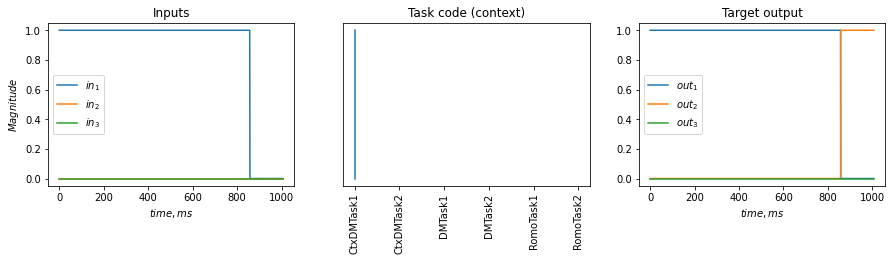

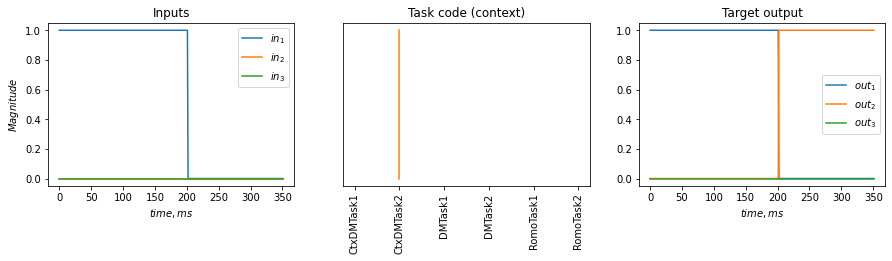

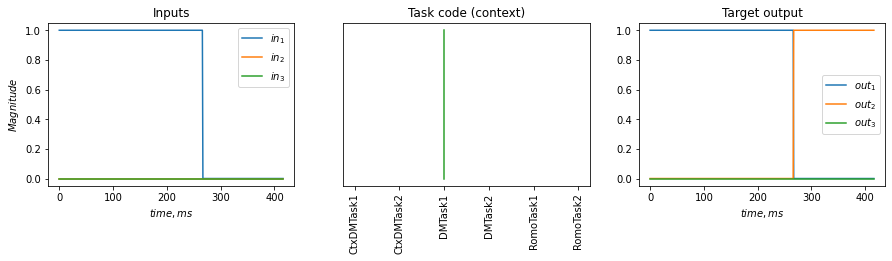

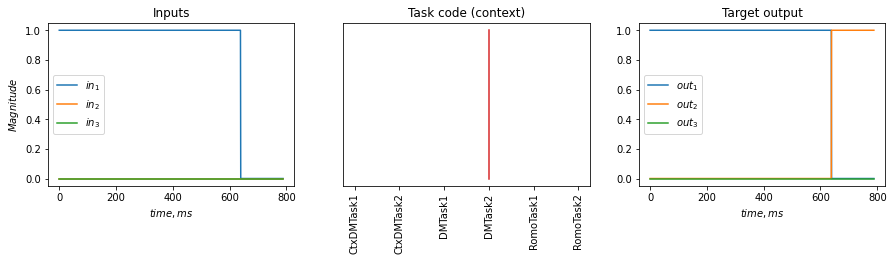

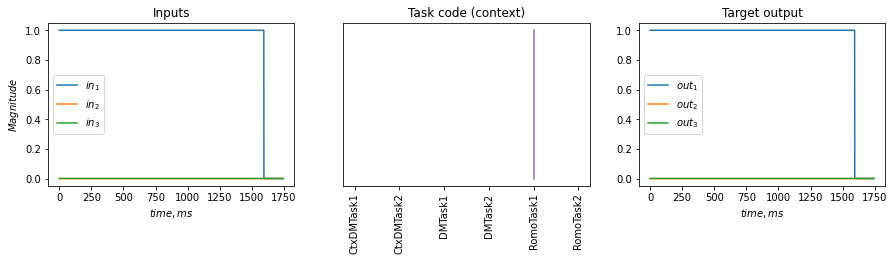

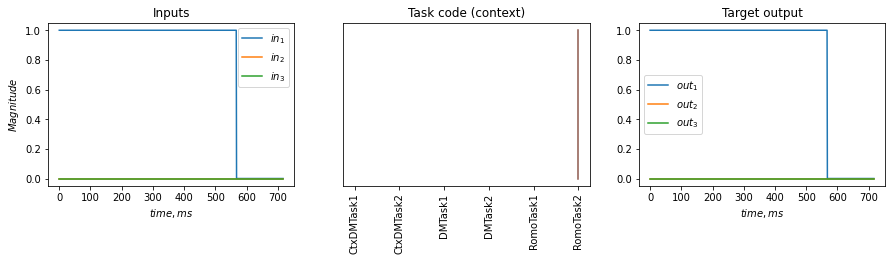

In [55]:
Task = generate_task(romo_parameters, dm_parameters, ctx_parameters)
for task_number in range(6):
    Task.task_number = task_number
    inputs, t_outputs = Task.dataset(n_trials=1)

    for bath in range(min(batch_size, 10)):
        fig = plt.figure(figsize=(15, 3))
        ax1 = fig.add_subplot(131)
        plt.title("Inputs")
        plt.xlabel("$time, ms$")
        plt.ylabel("$Magnitude$")
        for i in range(3):
            plt.plot(inputs[:, bath, i], label=rf"$in_{i + 1}$")
        plt.legend()
        # plt.tight_layout()

        ax2 = fig.add_subplot(132)
        plt.title("Task code (context)")
        plt.xticks(np.arange(1, len(tasks) + 1), sorted(tasks), rotation=90)
        plt.yticks([])
        for i in range(3, inputs.shape[-1]):
            plt.plot([i - 2] * 2, [0, inputs[0, bath, i]])
        # plt.tight_layout()

        ax3 = fig.add_subplot(133)
        plt.title("Target output")
        plt.xlabel("$time, ms$")
        for i in range(t_outputs.shape[-1]):
            plt.plot(t_outputs[:, bath, i], label=rf"$out_{i + 1}$")
        plt.legend()
        # plt.tight_layout()
    plt.show()
    plt.close()

# Загрузка модели

In [51]:
path = os.path.join("..", "..", "..", "models")
model_path = os.path.join(
    path, "romo_dm_ctx", "lif_adex", "noise_0_5_without_context_noise"
)
pmodel = os.path.join(
    model_path,
    "Train_dm_and_romo_task_reduce_lif_adex_without_refrac_random_delay_long_a_alpha_100_N_450",
)
ptau_ada = os.path.join(model_path, "tau_ada_inv_alpha=100.npy")
tau_ada = np.load(ptau_ada)
feature_size, output_size = Task.feature_and_act_size
hidden_size = 450

neuron_parameters = LIFAdExParameters(
    v_th=torch.as_tensor(0.65),
    tau_ada_inv=torch.from_numpy(tau_ada).to(device),
    alpha=100,
    method="super",
)
model = SNNlifadex(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=500,
).to(device)
model.load_state_dict(torch.load(pmodel))

<All keys matched successfully>

# DPCA ctx1, ctx2

In [57]:
input_values = [0, 0.1, 0.2, 0.3, 0.4, 0.49, 0.51, 0.6, 0.7, 0.8, 0.9, 1]
feature_size = 9
output_size = 3
hidden_size = 450
batch_size = 1
init_state = LIFAdExRefracInitState(batch_size, hidden_size)
first_state = init_state.zero_state()
second_state = init_state.random_state()
v_mean = None
a_mean = None
answer_time = 0.3
number_of_trials = 10
data_save = torch.zeros((0, 1, 4))
romo_parameters = RomoTaskRandomModParameters(
    romo=RomoTaskParameters(
        delay=1.2,
        positive_shift_delay_time=1.4,
        trial_time=0.1,
        positive_shift_trial_time=0.2,
        value=(0, 0),
    ),
)
dm_parameters = DMTaskRandomModParameters(dm=DMTaskParameters(trial_time=0.5, value=0))
ctx_parameters = CtxDMTaskParameters(dm=dm_parameters.dm, value=(0, 0))


dm_interval = round(
    (dm_parameters.dm.answer_time + dm_parameters.dm.trial_time) / dm_parameters.dm.dt
)
romo_interval = round(
    (
        romo_parameters.romo.answer_time
        + 2 * romo_parameters.romo.trial_time
        + romo_parameters.romo.delay
    )
    / romo_parameters.romo.dt
)
actR = np.zeros(
    (
        number_of_trials,
        hidden_size,
        len(input_values),
        romo_interval + dm_interval,
    )
)
actR_a = np.zeros_like(actR)
for trial in tqdm(range(number_of_trials)):
    v_save = torch.zeros((0, 1, hidden_size))
    a_save = torch.zeros((0, 1, hidden_size))
    for value in range(len(input_values)):
        dmparams = DMTaskParameters(
            trial_time=0.4,
            value=1 - input_values[value],
            answer_time=answer_time,
        )
        romoparams = RomoTaskParameters(
            delay=0.4,
            trial_time=0.15,
            value=(0.5, input_values[value]),
            answer_time=answer_time,
        )
        Task_dm = DMTask(dmparams, mode="value")
        data_dm, _ = Task_dm.dataset(1)
        rule_matrix = np.zeros((data_dm.shape[0], 1, 2))
        rule_matrix[:, :, 0] = 1
        data_dm = np.concatenate((data_dm, rule_matrix), axis=2)

        Task_romo = RomoTask(romoparams, mode="value")
        data_romo, _ = Task_romo.dataset(1)
        rule_matrix = np.zeros((data_romo.shape[0], 1, 2))
        rule_matrix[:, :, 1] = 1
        data_romo = np.concatenate((data_romo, rule_matrix), axis=2)

        data = np.concatenate((data_dm, data_romo), axis=0)
        data = torch.from_numpy(data).type(torch.float)
        out, states = model(data)
        v = []
        s = []
        a = []
        for j in range(len(states)):
            v.append(states[j].lif_adex.v)
            s.append(states[j].lif_adex.z)
            a.append(states[j].lif_adex.a)
        a = torch.stack(a).detach()
        v = torch.stack(v).detach()
        actR[trial, :, value, :] = v[:, 0, :].T.numpy()
        actR_a[trial, :, value, :] = a[:, 0, :].T.numpy()
        v_save = torch.concat((v_save, v), axis=0)
        a_save = torch.concat((a_save, a), axis=0)
        if trial == 0:
            data_save = torch.concat((data_save, data), axis=0)
s = torch.stack(s).detach()
s = s.cpu().numpy()

  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x4 and 9x450)

# Пример последнего выхода

In [ ]:
plt.figure()
plt.plot(out.cpu().detach().numpy()[:, 0, :])
plt.show()
plt.close()

# Пример последнего входа

In [ ]:
plt.figure()
plt.plot(data.cpu().detach().numpy()[:, 0, 1])
plt.show()
plt.close()

# DPCA по мембранному потенциалу

In [ ]:
R = np.mean(actR, 0)
R -= np.mean(R.reshape((hidden_size, -1)), 1)[:, None, None]
dpca = dPCA.dPCA(labels="st", regularizer="auto")
dpca.protect = ["t"]
Z = dpca.fit_transform(R, actR)

time = np.arange(actR.shape[-1])
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
for s in range(actR.shape[0]):
    ax1.plot(time, Z["t"][0, s])
for s in range(actR.shape[0]):
    ax2.plot(time, Z["s"][0, s])
for s in range(actR.shape[0]):
    ax3.plot(time, Z["st"][0, s])

In [ ]:
% matplotlib widget
from matplotlib.pyplot import cm

plt.figure(figsize=(16, 7))
plt.subplot(131)
S = actR.shape[2]
color = iter(cm.rainbow(np.linspace(0, 1, S)))
for s in range(S):
    c = next(color)
    plt.plot(time, Z["t"][0, s], c=c)

plt.title("1st time component")

plt.subplot(132)
color = iter(cm.rainbow(np.linspace(0, 1, S)))

for s in range(S):
    c = next(color)
    plt.plot(time, Z["s"][0, s], label=f"x={input_values[s]}", c=c)
plt.legend()
plt.title("1st stimulus component")

plt.subplot(133)
color = iter(cm.rainbow(np.linspace(0, 1, S)))

for s in range(S):
    c = next(color)

    plt.plot(time, Z["st"][0, s], label=f"x={input_values[s]}", c=c)
plt.legend()
plt.title("1st mixing component")
# plt.savefig('во время отклика dpca.pdf')
plt.show()

# DPCA по адаптивному потенциалу


In [ ]:
R = np.mean(actR_a, 0)
R -= np.mean(R.reshape((hidden_size, -1)), 1)[:, None, None]
dpca = dPCA.dPCA(labels="st", regularizer="auto")
dpca.protect = ["t"]
Z = dpca.fit_transform(R, actR_a)

time = np.arange(actR_a.shape[-1])
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
for s in range(actR_a.shape[0]):
    ax1.plot(time, Z["t"][0, s])
for s in range(actR_a.shape[0]):
    ax2.plot(time, Z["s"][0, s])
for s in range(actR_a.shape[0]):
    ax3.plot(time, Z["st"][0, s])

In [ ]:
% matplotlib widget
from matplotlib.pyplot import cm

plt.figure(figsize=(16, 7))
plt.subplot(131)
S = actR.shape[2]
color = iter(cm.rainbow(np.linspace(0, 1, S)))
for s in range(S):
    c = next(color)
    plt.plot(time, Z["t"][0, s], c=c)

plt.title("1st time component")

plt.subplot(132)
color = iter(cm.rainbow(np.linspace(0, 1, S)))

for s in range(S):
    c = next(color)
    plt.plot(time, Z["s"][0, s], label=f"x={input_values[s]}", c=c)
plt.legend()
plt.title("1st stimulus component")

plt.subplot(133)
color = iter(cm.rainbow(np.linspace(0, 1, S)))

for s in range(S):
    c = next(color)

    plt.plot(time, Z["st"][0, s], label=f"x={input_values[s]}", c=c)
plt.legend()
plt.title("1st mixing component")
# plt.savefig('во время отклика dpca.pdf')
plt.show()